## D1. Build ULTIMATE MASK from cloud mask and valid data 

In [10]:
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Build an EOTask for mrging the masks

In [49]:
class ConcatenateMasks(EOTask):
    
    """Task to concatenate "mask arrays to produce one ultimate mask"""
    
    def __init__(self, in_neg_to_fil_out, in_pos_to_fil_out, output_mask_name):
        
        self.output_mask_name = output_mask_name
        self.in_neg_to_fil_out = in_neg_to_fil_out
        self.in_pos_to_fil_out = in_pos_to_fil_out

    def execute(self, eopatch):
        
        neg_arrays = [eopatch.mask[name] for name in self.in_neg_to_fil_out]
        pos_arrays = [eopatch.mask[name] for name in self.in_pos_to_fil_out]
        
        if len(neg_arrays) > 0 :
            mask_shape = neg_arrays[-1].shape
        elif len(pos_arrays) > 0 :
            mask_shape = pos_arrays[-1].shape
        else:
            print('No data mask provided')
            return
            
        invalid_data_mask = np.full(mask_shape, False)
        
        for arr in neg_arrays:
            arr = np.bitwise_not(arr)
            invalid_data_mask = np.ma.mask_or(invalid_data_mask, arr)
            
        for arr in pos_arrays:
            invalid_data_mask = np.ma.mask_or(invalid_data_mask, arr)
    
        eopatch.add_feature(FeatureType.MASK, self.output_mask_name, invalid_data_mask )

        return eopatch

In [125]:
negative_masks_to_ctn = ['IS_DATA','MODIS_IS_DATA_DAY_0']
positive_mask_to_ctn = ['CLOUD_MASK_SWIR-1_150_dil_6_str1']
invalid_mask_eo_task = ConcatenateMasks( negative_masks_to_ctn, positive_mask_to_ctn,  'INVALID_DATA_MASK_CLD_150_STR1-IS_LDS-IS_MDS')

In [127]:

for date_range_landsat in site.DATE_RANGES_LANDSAT_8 :
    print('Reading EOPatches from:', date_range_landsat )
    eopatches_filepath = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[1], site.SITE_NAME, site.AVAILABLE_CRSs[0], date_range_landsat)
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(eopatches_filepath)
    save_eotask = SaveTask(eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    invalid_mask_eo_task,
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    execution_args = []
    for eopatch_name in list_of_available_patches:
        execution_args.append({
        load_eotask: {'eopatch_folder': eopatch_name},
        save_eotask: {'eopatch_folder': eopatch_name}
        })
    #print(execution_args)                            
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=1, multiprocess=False)

    executor.make_report()

Reading EOPatches from: ('2013-05-01', '2013-10-31')



Reading EOPatches from: ('2014-05-01', '2014-10-31')



Reading EOPatches from: ('2015-05-01', '2015-10-31')



Reading EOPatches from: ('2016-05-01', '2016-10-31')



Reading EOPatches from: ('2017-05-01', '2017-10-31')



Reading EOPatches from: ('2018-05-01', '2018-10-31')



Reading EOPatches from: ('2019-05-01', '2019-10-31')


In [128]:
eo_patch = EOPatch.load('../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/2969_maxcc_0.05_x-3_y-130')
eo_patch

EOPatch(
  data: {
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(23, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(23, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(23, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS_DAY_0: numpy.ndarray(shape=(23, 333, 333, 7), dtype=float32)
    MODIS_RAW_BANDS_DAY_AFTER: numpy.nda

2019-05-30 00:00:49
Ploting...


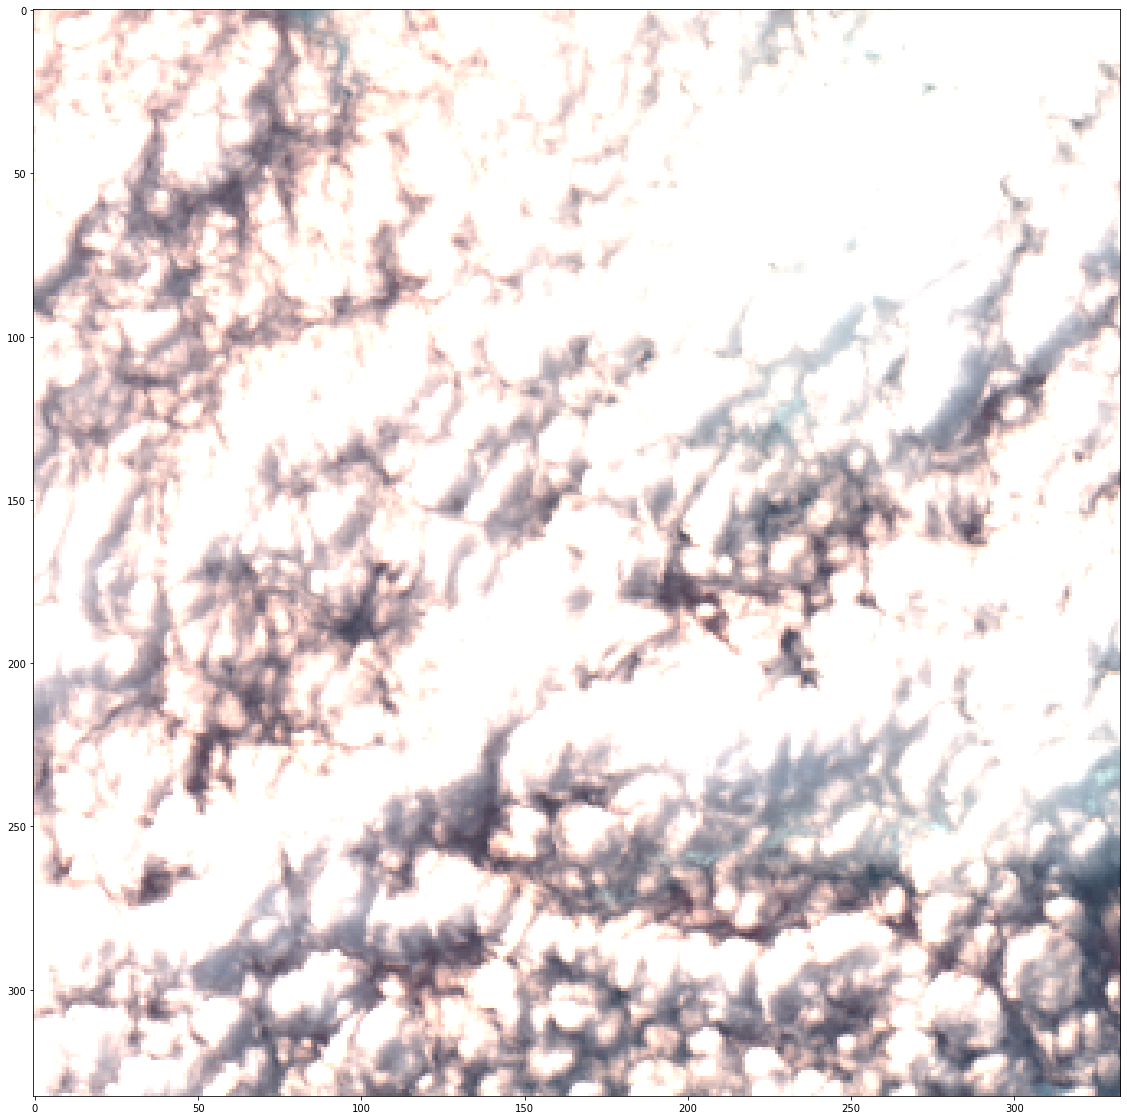

In [130]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, data_acces_name='LANDSAT_RAW_BANDS', datetime_idx=5, save=False)

2019-05-30 00:00:49


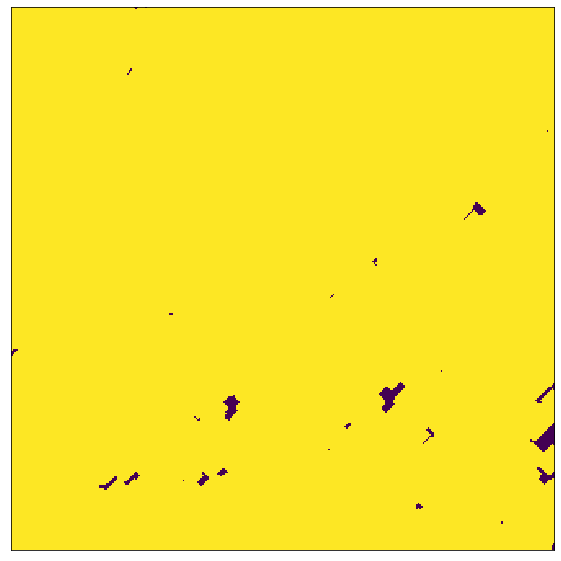

In [132]:
plot_utils.plot_single_mask_LANDSAT_8(eo_patch, band_idx = 0, data_acces_name='INVALID_DATA_MASK_CLD_150_STR1-IS_LDS-IS_MDS', datetime_idx=5, save=False)

2019-05-30 00:00:49


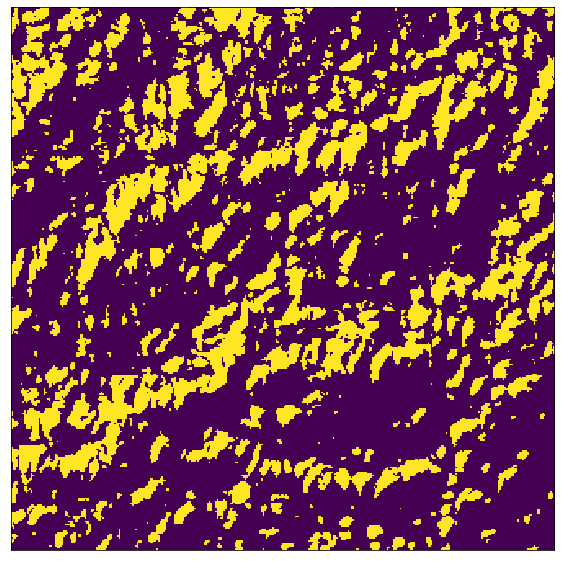

In [115]:
plot_utils.plot_single_mask_LANDSAT_8(eo_patch, band_idx = 0, data_acces_name='CLOUD_MASK_SWIR-1_300', datetime_idx=5, save=False)